<a href="https://colab.research.google.com/github/MartinFarres/fuzzyApriori-DogsBreed/blob/main/fuzzyApriori_DogsBreed.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fuzzy Apriori - Dogs Breed Dataset
Standard Apriori is designed for binary "yes/no" data (e.g., items in a shopping cart). Our breed_traits.csv dataset, however, contains quantitative ratings from 1 to 5, making standard Apriori unusable.

We will use the Fuzzy-Apriori algorithm to solve this. This approach converts our crisp numerical ratings into overlapping, linguistic "fuzzy sets" (e.g., Low, Medium, High) using membership functions. For example, a Shedding Level of 4 isn't just a "4"; it becomes partially "Medium" and partially "High."

The Apriori algorithm is then modified to find frequent patterns by summing these partial membership scores instead of just counting transactions. This allows us to discover far more nuanced and realistic association rules, such as "Breeds with a High energy level are strongly associated with also having a High trainability level."

In [135]:
import pandas as pd

# Read the breed_traits.csv file into a pandas DataFrame
df = pd.read_csv('/content/breed_traits.csv')

# Display the first few rows of the DataFrame
display(df.head())

,Breed,Affectionate With Family,Good With Young Children,Good With Other Dogs,Shedding Level,Coat Grooming Frequency,Drooling Level,Coat Type,Coat Length,Openness To Strangers,Playfulness Level,Watchdog/Protective Nature,Adaptability Level,Trainability Level,Energy Level,Barking Level,Mental Stimulation Needs
0,Retrievers (Labrador),5,5,5,4,2,2,Double,Short,5,5,3,5,5,5,3,4
1,French Bulldogs,5,5,4,3,1,3,Smooth,Short,5,5,3,5,4,3,1,3
2,German Shepherd Dogs,5,5,3,4,2,2,Double,Medium,3,4,5,5,5,5,3,5
3,Retrievers (Golden),5,5,5,4,2,2,Double,Medium,5,4,3,5,5,3,1,4
4,Bulldogs,4,3,3,3,3,3,Smooth,Short,4,4,3,3,4,3,2,3


## Step 1 - Fuzzification & Create Fuzzy Transactions
First, we fuzzify our quantitative data by defining membership functions (e.g., triangular rules) to translate crisp numerical ratings (1-5) into meaningful, overlapping linguistic terms like Low, Medium, and High.

This process converts each breed into a fuzzy transaction, where every trait now has a "degree of membership" (a score from 0.0 to 1.0) in these fuzzy sets.

For example, a crisp rating of 4 for Energy Level might be converted to:

- Energy=Low: 0.0
- Energy=Medium: 0.5
- Energy=High: 0.5

In [136]:
def low_membership(rating):
    if rating == 1:
        return 1.0
    elif rating == 2:
        return 0.5
    else:
        return 0.0

def medium_membership(rating):
    if rating == 3:
        return 1.0
    elif rating == 2 or rating == 4:
        return 0.5
    else:
        return 0.0

def high_membership(rating):
    if rating == 5:
        return 1.0
    elif rating == 4:
        return 0.5
    else:
        return 0.0

# Identify the numerical rating columns (excluding 'Breed', 'Coat Type', 'Coat Length')
numerical_cols = df.columns.drop(['Breed', 'Coat Type', 'Coat Length'])

# Create new columns for each fuzzy set for each numerical column
for col in numerical_cols:
    df[f'{col}_Low'] = df[col].apply(low_membership)
    df[f'{col}_Medium'] = df[col].apply(medium_membership)
    df[f'{col}_High'] = df[col].apply(high_membership)

# Display the head of the modified DataFrame to show the new fuzzy set columns
display(df.head())

,Breed,Affectionate With Family,Good With Young Children,Good With Other Dogs,Shedding Level,Coat Grooming Frequency,Drooling Level,Coat Type,Coat Length,Openness To Strangers,...,Trainability Level_High,Energy Level_Low,Energy Level_Medium,Energy Level_High,Barking Level_Low,Barking Level_Medium,Barking Level_High,Mental Stimulation Needs_Low,Mental Stimulation Needs_Medium,Mental Stimulation Needs_High
0,Retrievers (Labrador),5,5,5,4,2,2,Double,Short,5,...,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.5,0.5
1,French Bulldogs,5,5,4,3,1,3,Smooth,Short,5,...,0.5,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
2,German Shepherd Dogs,5,5,3,4,2,2,Double,Medium,3,...,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
3,Retrievers (Golden),5,5,5,4,2,2,Double,Medium,5,...,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.5,0.5
4,Bulldogs,4,3,3,3,3,3,Smooth,Short,4,...,0.5,0.0,1.0,0.0,0.5,0.5,0.0,0.0,1.0,0.0


In [137]:
# Identify the fuzzy columns (ending with _Low, _Medium, _High)
fuzzy_cols = [col for col in df.columns if col.endswith('_Low') or col.endswith('_Medium') or col.endswith('_High')]

# Identify the crisp columns to keep
crisp_cols_to_keep = ['Breed', 'Coat Type', 'Coat Length']

# Combine the crisp and fuzzy column names
cols_to_keep = crisp_cols_to_keep + fuzzy_cols

# Create a new DataFrame with only the desired columns
df_fuzzy = df[cols_to_keep].copy()

# Display the head of the new DataFrame
display(df_fuzzy.head())

,Breed,Coat Type,Coat Length,Affectionate With Family_Low,Affectionate With Family_Medium,Affectionate With Family_High,Good With Young Children_Low,Good With Young Children_Medium,Good With Young Children_High,Good With Other Dogs_Low,...,Trainability Level_High,Energy Level_Low,Energy Level_Medium,Energy Level_High,Barking Level_Low,Barking Level_Medium,Barking Level_High,Mental Stimulation Needs_Low,Mental Stimulation Needs_Medium,Mental Stimulation Needs_High
0,Retrievers (Labrador),Double,Short,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.5,0.5
1,French Bulldogs,Smooth,Short,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.5,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
2,German Shepherd Dogs,Double,Medium,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
3,Retrievers (Golden),Double,Medium,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.5,0.5
4,Bulldogs,Smooth,Short,0.0,0.5,0.5,0.0,1.0,0.0,0.0,...,0.5,0.0,1.0,0.0,0.5,0.5,0.0,0.0,1.0,0.0


## Step 2 - Run the Fuzzy-Apriori Algorithm
Here is a brief explanation for that step.

Step 2 - Run the Fuzzy-Apriori Algorithm

With our "fuzzy transactions" ready, we now run the core algorithm to find frequent patterns. This process iteratively:

- **Finds L1 (Frequent 1-Itemsets)**: It first calculates the FuzzySupport for all single items (e.g., Energy=High) by summing their membership scores across all breeds and dividing by the total. It keeps only those ≥ min_support.

- **Generates & Prunes (Lk):** It then enters a loop, using the frequent itemsets from the previous step (L_k-1_) to generate a new list of candidates (C_k_).

- **Calculates Support:** It calculates the FuzzySupport for each new candidate by summing the minimum membership score of its items across all breeds.

- **Filters:** It keeps only the candidates that meet min_support, creating the new list of frequent itemsets (L_k_).

This loop repeats (L2, L3, L4...) until no new frequent itemsets can be found.

In [138]:
def fuzzy_apriori(df, min_support):
    frequent_itemsets = {}
    k = 1

    # Step 1: Finds L1 (Frequent 1-Itemsets)
    candidate_itemsets_k = [(col,) for col in df.columns if col not in ['Breed', 'Coat Type', 'Coat Length']]
    frequent_itemsets_k = []
    for itemset in candidate_itemsets_k:
        support = calculate_fuzzy_support(df, list(itemset))
        if support >= min_support:
            frequent_itemsets_k.append({'itemset': itemset, 'support': support})
    frequent_itemsets[k] = frequent_itemsets_k

    # Step 2: Generates & Prunes (Lk) - Loop for finding frequent k-itemsets for k > 1
    while frequent_itemsets_k:
        k += 1
        # Generates candidates (Ck) from frequent (k-1)-itemsets (L_k-1_)
        candidate_itemsets_k = generate_candidates(frequent_itemsets_k, k)
        frequent_itemsets_k = []
        for itemset in candidate_itemsets_k:
            # Step 3: Calculates Support for each new candidate
            support = calculate_fuzzy_support(df, list(itemset))
            if support >= min_support:
                # Step 4: Filters - Keeps only the candidates that meet min_support, creating the new list of frequent itemsets (L_k_)
                frequent_itemsets_k.append({'itemset': itemset, 'support': support})
        if frequent_itemsets_k:
            frequent_itemsets[k] = frequent_itemsets_k

    return frequent_itemsets

def calculate_fuzzy_support(df, itemset):
    if not isinstance(itemset, (list, tuple)):
        itemset = [itemset]
    if not itemset:
        return 0.0
    # Calculate the minimum membership for the itemset for each transaction (breed)
    min_memberships = df[itemset].min(axis=1)
    # Sum the minimum memberships and divide by the total number of transactions
    fuzzy_support = min_memberships.sum() / len(df)
    return fuzzy_support

def generate_candidates(frequent_itemsets_prev_k, k):
    candidates = set()
    for i in range(len(frequent_itemsets_prev_k)):
        for j in range(i + 1, len(frequent_itemsets_prev_k)):
            itemset1 = sorted(list(frequent_itemsets_prev_k[i]['itemset']))
            itemset2 = sorted(list(frequent_itemsets_prev_k[j]['itemset']))

            # Join step: If the first k-2 items are the same, combine the itemsets
            if k > 2 and itemset1[:k-2] != itemset2[:k-2]:
                continue
            if itemset1[-1] != itemset2[-1]: # Ensure unique combination
                 new_itemset = tuple(sorted(list(set(itemset1 + itemset2))))
                 if len(new_itemset) == k:
                     candidates.add(new_itemset)

    # Prune step: Remove candidates that have infrequent subsets
    pruned_candidates = []
    for candidate in candidates:
        is_valid = True
        for i in range(k):
            subset = tuple(sorted(list(candidate[:i] + candidate[i+1:])))
            # Check if the subset is in the frequent itemsets of the previous level (L_k-1_)
            if k > 2 and not any(set(subset) == set(itemset['itemset']) for itemset in frequent_itemsets_prev_k):
                 is_valid = False
                 break
        if is_valid:
             pruned_candidates.append(candidate)

    return pruned_candidates

# Run the Algorithm
min_support = 0.35
frequent_itemsets = fuzzy_apriori(df_fuzzy, min_support)

In [139]:
if 'frequent_itemsets' in locals():
    print("--- Top 5 Frequent Itemsets by Support ---")

    if not frequent_itemsets:
        print("No frequent itemsets found with the given minimum support.")

    for k, itemsets in frequent_itemsets.items():
        print(f"\n## Frequent {k}-itemsets (Top 5, Support >= {min_support}):")

        sorted_itemsets = sorted(itemsets, key=lambda x: x['support'], reverse=True)

        top_5_itemsets = sorted_itemsets[:5]

        if not top_5_itemsets:
            print("  (No itemsets found at this level)")
            continue

        for i, itemset_info in enumerate(top_5_itemsets):
            itemset_str = ", ".join(itemset_info['itemset'])
            print(f"  {i+1}. ({itemset_str}): {itemset_info['support']:.4f}")
else:
    print("Please define 'df_fuzzy' and 'min_support' and run 'fuzzy_apriori' to generate itemsets.")

--- Top 5 Frequent Itemsets by Support ---

## Frequent 1-itemsets (Top 5, Support >= 0.35):
  1. (Affectionate With Family_High): 0.7513
  2. (Shedding Level_Medium): 0.7051
  3. (Openness To Strangers_Medium): 0.6769
  4. (Good With Other Dogs_Medium): 0.6744
  5. (Playfulness Level_Medium): 0.6667

## Frequent 2-itemsets (Top 5, Support >= 0.35):
  1. (Mental Stimulation Needs_Medium, Playfulness Level_Medium): 0.5462
  2. (Affectionate With Family_High, Shedding Level_Medium): 0.5462
  3. (Openness To Strangers_Medium, Playfulness Level_Medium): 0.5410
  4. (Energy Level_Medium, Mental Stimulation Needs_Medium): 0.5385
  5. (Adaptability Level_Medium, Playfulness Level_Medium): 0.5308

## Frequent 3-itemsets (Top 5, Support >= 0.35):
  1. (Energy Level_Medium, Mental Stimulation Needs_Medium, Playfulness Level_Medium): 0.4667
  2. (Adaptability Level_Medium, Mental Stimulation Needs_Medium, Playfulness Level_Medium): 0.4590
  3. (Adaptability Level_Medium, Openness To Strangers_Med

/tmp/ipython-input-2733988499.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='support', y='itemset', data=frequent_itemsets_df, palette='viridis')


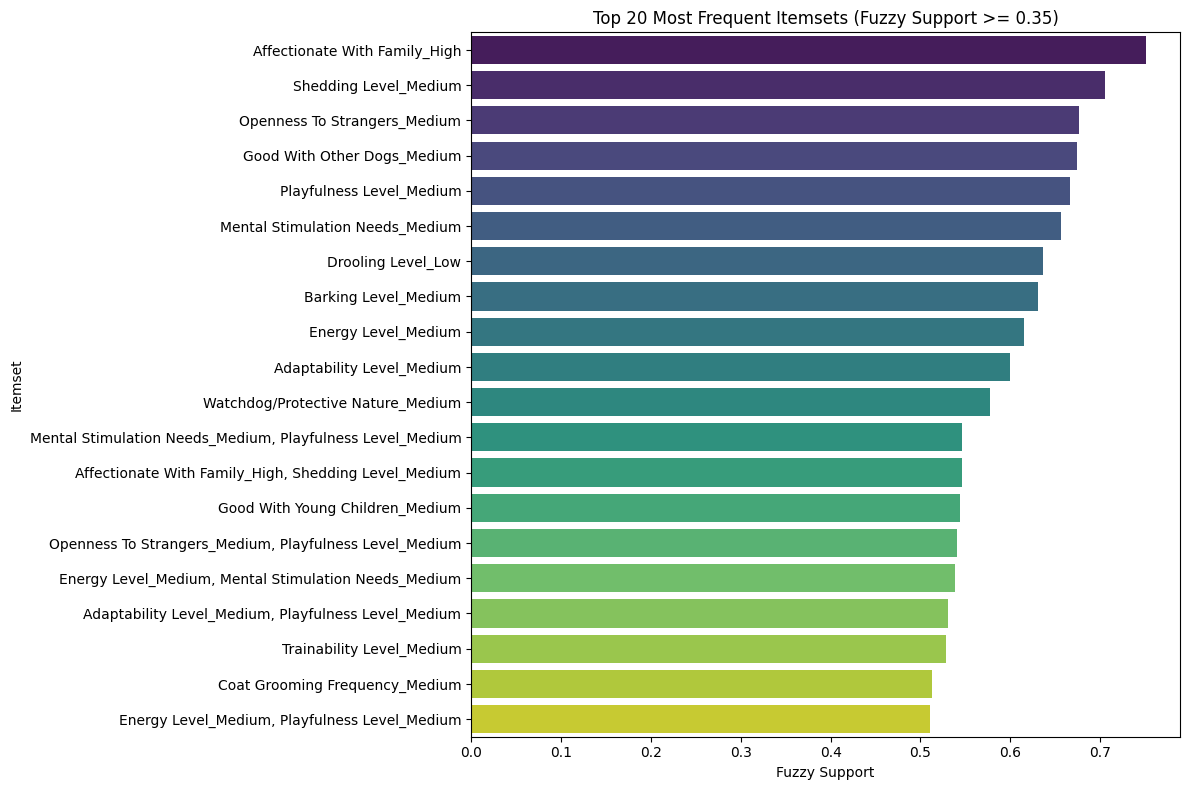

In [140]:
import matplotlib.pyplot as plt
import seaborn as sns


all_frequent_itemsets = []
for k, itemsets in frequent_itemsets.items():
    for itemset_info in itemsets:
        itemset_str = ', '.join(itemset_info['itemset'])
        all_frequent_itemsets.append({'itemset': itemset_str, 'support': itemset_info['support']})

frequent_itemsets_df = pd.DataFrame(all_frequent_itemsets)

top_n = 20
frequent_itemsets_df = frequent_itemsets_df.sort_values(by='support', ascending=False).head(top_n)

plt.figure(figsize=(12, 8))
sns.barplot(x='support', y='itemset', data=frequent_itemsets_df, palette='viridis')
plt.title(f'Top {top_n} Most Frequent Itemsets (Fuzzy Support >= {min_support})')
plt.xlabel('Fuzzy Support')
plt.ylabel('Itemset')
plt.tight_layout()
plt.savefig("most_frequent_itemsets.png")
plt.show()

## Step 3 - Generate and Interpret Fuzzy Rules
Now that we have our list of frequent itemsets, we can generate association rules.

For a frequent itemset (`e.g., {Energy=High, Playfulness=High})`, we create potential rules `(like Energy=High -> Playfulness=High)`. We then test the strength of each rule by calculating its Fuzzy Confidence using the formula:

    Confidence(A -> B) = FuzzySupport(A U B) / FuzzySupport(A)

We filter these using a min_confidence threshold (e.g., 0.7). The final output is a set of strong, interpretable rules like, `"We are 70% confident that breeds with a High Energy Level also have a High Playfulness Level."`

In [141]:
def generate_association_rules(frequent_itemsets, min_confidence):
    association_rules = []
    for k, itemsets in frequent_itemsets.items():
        if k < 2:  # Rules require at least two items
            continue

        for itemset_info in itemsets:
            itemset = itemset_info['itemset']
            support_itemset = itemset_info['support']

            # Generate all possible non-empty proper subsets of the itemset
            subsets = get_subsets(itemset)

            for subset_a in subsets:
                # The consequent (B) is the itemset minus the antecedent (A)
                subset_b = tuple(sorted(list(set(itemset) - set(subset_a))))

                # Ensure both antecedent and consequent are not empty
                if subset_a and subset_b:
                    support_a = calculate_fuzzy_support(df_fuzzy, list(subset_a))
                    support_b = calculate_fuzzy_support(df_fuzzy, list(subset_b))

                    # Calculate confidence (handle division by zero)
                    confidence = support_itemset / support_a if support_a > 0 else 0.0

                    # Calculate lift (handle division by zero)
                    lift = confidence / support_b if support_b > 0 else float('inf')

                    if confidence >= min_confidence:
                        association_rules.append({
                            'antecedent': subset_a,
                            'consequent': subset_b,
                            'support': support_itemset,
                            'confidence': confidence,
                            'lift': lift
                        })
    return association_rules

def get_subsets(itemset):
    subsets = []
    for i in range(1, 2**len(itemset) - 1): # Exclude empty set and the itemset itself
        subset = tuple(sorted([itemset[j] for j in range(len(itemset)) if (i >> j) & 1]))
        subsets.append(subset)
    return subsets


min_confidence = 0.93
association_rules = generate_association_rules(frequent_itemsets, min_confidence)



In [142]:
print(f"\n--- Association Rules (Confidence >= {min_confidence}) ---")
if not association_rules:
    print("No association rules found with the given minimum confidence.")
else:
    sorted_rules = sorted(association_rules, key=lambda x: x['confidence'], reverse=True)
    for rule in sorted_rules:
        antecedent_str = ", ".join(rule['antecedent'])
        consequent_str = ", ".join(rule['consequent'])
        print(f"Rule: ({antecedent_str}) --> ({consequent_str})")
        print(f"  Support: {rule['support']:.4f}, Confidence: {rule['confidence']:.4f}, Lift: {rule['lift']:.4f}")


--- Association Rules (Confidence >= 0.93) ---
Rule: (Adaptability Level_Medium, Energy Level_Medium, Openness To Strangers_Medium) --> (Playfulness Level_Medium)
  Support: 0.3538, Confidence: 0.9787, Lift: 1.4681
Rule: (Adaptability Level_High) --> (Affectionate With Family_High)
  Support: 0.3846, Confidence: 0.9740, Lift: 1.2965
Rule: (Adaptability Level_Medium, Mental Stimulation Needs_Medium, Openness To Strangers_Medium) --> (Playfulness Level_Medium)
  Support: 0.3897, Confidence: 0.9682, Lift: 1.4522
Rule: (Energy Level_Medium, Playfulness Level_Medium, Trainability Level_Medium) --> (Mental Stimulation Needs_Medium)
  Support: 0.3692, Confidence: 0.9664, Lift: 1.4723
Rule: (Adaptability Level_Medium, Energy Level_Medium, Mental Stimulation Needs_Medium) --> (Playfulness Level_Medium)
  Support: 0.3923, Confidence: 0.9623, Lift: 1.4434
Rule: (Energy Level_Medium, Trainability Level_Medium) --> (Mental Stimulation Needs_Medium)
  Support: 0.3949, Confidence: 0.9565, Lift: 1.45

# Visualization

## Preprocessing of data for Plotting

In [143]:
rules_for_plotting = []
for rule in association_rules:
    antecedent_str = ", ".join(rule['antecedent'])
    consequent_str = ", ".join(rule['consequent'])
    rules_for_plotting.append({
        'antecedent': antecedent_str,
        'consequent': consequent_str,
        'support': rule['support'],
        'confidence': rule['confidence'],
        'lift': rule['lift']
    })

# Display the first few rules for verification
if rules_for_plotting:
    print("--- First 5 Rules for Plotting ---")
    for i in range(min(5, len(rules_for_plotting))):
        print(rules_for_plotting[i])
else:
    print("No rules generated for plotting.")

--- First 5 Rules for Plotting ---
{'antecedent': 'Adaptability Level_High', 'consequent': 'Affectionate With Family_High', 'support': np.float64(0.38461538461538464), 'confidence': np.float64(0.9740259740259741), 'lift': np.float64(1.2964850848809895)}
{'antecedent': 'Adaptability Level_Medium, Trainability Level_Medium', 'consequent': 'Mental Stimulation Needs_Medium', 'support': np.float64(0.382051282051282), 'confidence': np.float64(0.9371069182389936), 'lift': np.float64(1.427623820754717)}
{'antecedent': 'Adaptability Level_Medium, Energy Level_Medium', 'consequent': 'Mental Stimulation Needs_Medium', 'support': np.float64(0.4076923076923077), 'confidence': np.float64(0.9352941176470588), 'lift': np.float64(1.4248621323529411)}
{'antecedent': 'Adaptability Level_Medium, Trainability Level_Medium', 'consequent': 'Playfulness Level_Medium', 'support': np.float64(0.382051282051282), 'confidence': np.float64(0.9371069182389936), 'lift': np.float64(1.4056603773584906)}
{'antecedent': 

## Generate support vs. confidence scatter plot



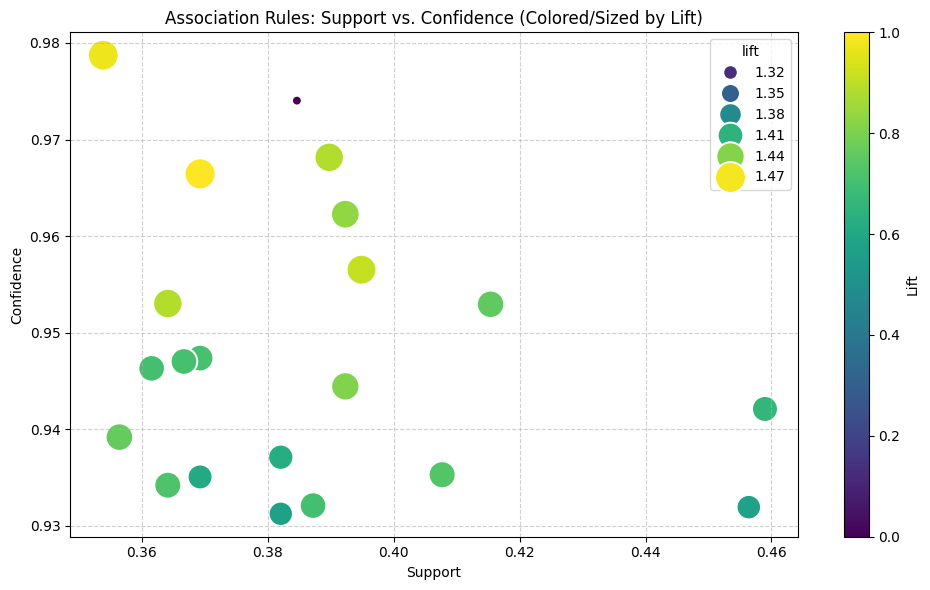

In [144]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Convert the list of dictionaries to a DataFrame for easier plotting with seaborn
rules_df = pd.DataFrame(rules_for_plotting)

plt.figure(figsize=(10, 6))
scatter = sns.scatterplot(
    x='support',
    y='confidence',
    hue='lift',         # Color points by lift
    size='lift',        # Size points by lift
    sizes=(50, 500),    # Adjust size range for better visualization
    palette='viridis',  # Use a colormap
    data=rules_df
)

plt.title('Association Rules: Support vs. Confidence (Colored/Sized by Lift)')
plt.savefig("association_rules_support_vs_confidence.png")
plt.xlabel('Support')
plt.ylabel('Confidence')

# Get the mappable object from the scatter plot artist
mappable = scatter.collections[0]
plt.colorbar(mappable, label='Lift') # Add a colorbar using the mappable

plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

## Generate network graph



Saved 'association_rules_network_improved.png'


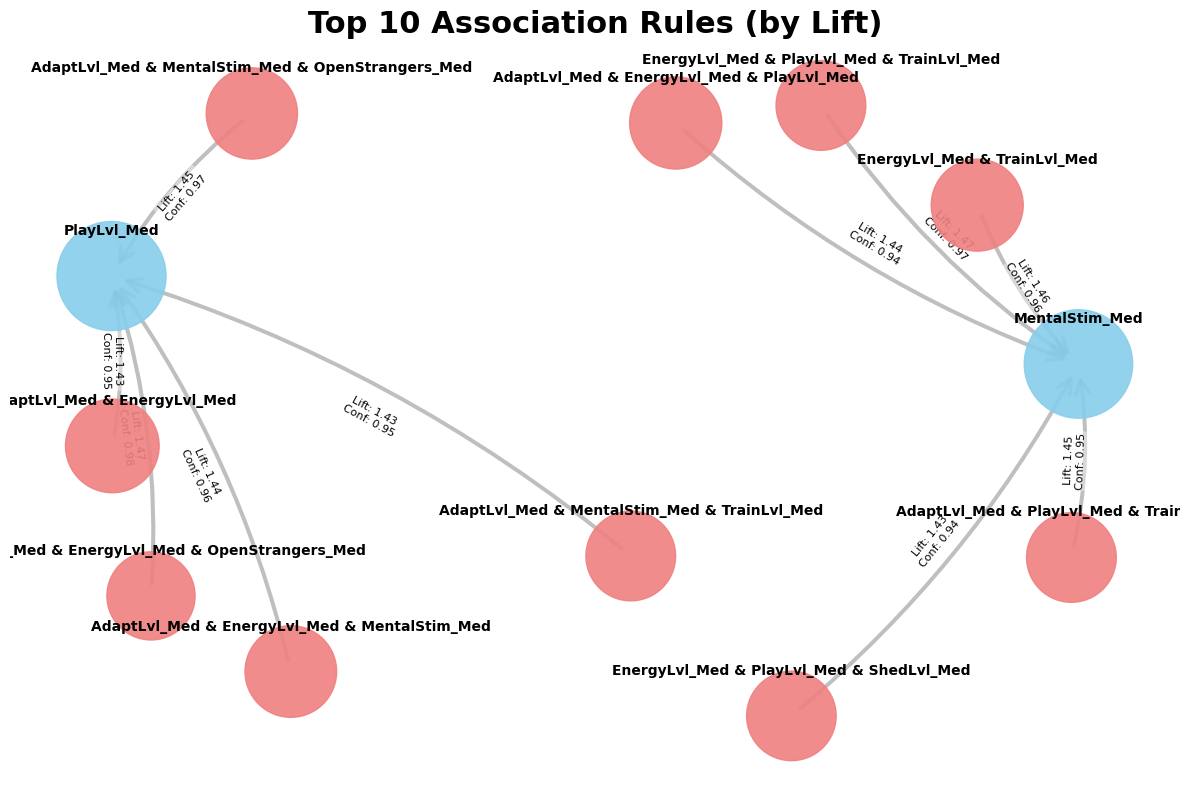

In [145]:
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import math


def summarize_label(label):
    # (Your summarize_label function is great, no changes needed)
    label = label.replace('Affectionate With Family', 'AffecFam')
    label = label.replace('Good With Young Children', 'GoodYngChild')
    label = label.replace('Good With Other Dogs', 'GoodOthrDog')
    label = label.replace('Shedding Level', 'ShedLvl')
    label = label.replace('Coat Grooming Frequency', 'CoatGrmFreq')
    label = label.replace('Drooling Level', 'DroolLvl')
    label = label.replace('Openness To Strangers', 'OpenStrangers')
    label = label.replace('Playfulness Level', 'PlayLvl')
    label = label.replace('Watchdog/Protective Nature', 'WatchdogNat')
    label = label.replace('Adaptability Level', 'AdaptLvl')
    label = label.replace('Trainability Level', 'TrainLvl')
    label = label.replace('Energy Level', 'EnergyLvl')
    label = label.replace('Barking Level', 'BarkLvl')
    label = label.replace('Mental Stimulation Needs', 'MentalStim')
    label = label.replace('_Medium', '_Med').replace('_High', '_High').replace('_Low', '_Low')
    return label

# --- 1. PRE-PROCESSING FOR VISUALIZATION ---

if not association_rules:
    print("No association rules to visualize.")
else:
    # --- CHANGE 1: Filter for the Top 10 rules ---
    top_n_rules = 10
    rules_df = pd.DataFrame(association_rules)
    top_rules_df = rules_df.sort_values(by='lift', ascending=False).head(top_n_rules)

    # Create a support map to size the nodes
    # This maps the original itemset tuple to its support
    support_map = {}
    for k, itemsets in frequent_itemsets.items():
        for item_info in itemsets:
            support_map[item_info['itemset']] = item_info['support']

    # Map for summarized node names back to their original tuple
    summary_to_tuple_map = {}

    # --- 2. BUILD THE GRAPH ---
    G = nx.DiGraph()

    for _, rule in top_rules_df.iterrows():
        antecedent_tuple = rule['antecedent']
        consequent_tuple = rule['consequent']

        # Summarize labels for display
        antecedent_summary = summarize_label(" & ".join(antecedent_tuple))
        consequent_summary = summarize_label(" & ".join(consequent_tuple))

        # Store mapping to get support later
        summary_to_tuple_map[antecedent_summary] = antecedent_tuple
        summary_to_tuple_map[consequent_summary] = consequent_tuple

        # Add nodes (duplicates are automatically handled)
        G.add_node(antecedent_summary)
        G.add_node(consequent_summary)

        # Add the directed edge with all metrics as attributes
        G.add_edge(
            antecedent_summary,
            consequent_summary,
            lift=rule['lift'],
            confidence=rule['confidence'],
            support=rule['support']
        )

    # --- 3. DEFINE DYNAMIC VISUAL PROPERTIES ---

    # Set node sizes based on their individual support
    # We scale support (0-1) to a visible size (e.g., 2000-15000)
    node_sizes = []
    for node in G.nodes():
        node_tuple = summary_to_tuple_map.get(node)
        if node_tuple:
            support = support_map.get(node_tuple, 0.1) # Get support, default to small size
            node_sizes.append(1500 + (support * 7000))
        else:
            node_sizes.append(1500) # Default size if mapping fails

    # Set node colors based on complexity (your original, smart idea)
    node_colors = ['lightcoral' if " & " in node else 'skyblue' for node in G.nodes()]

    # Set edge widths based on 'lift'
    edge_widths = [d['lift'] * 2 for u, v, d in G.edges(data=True)] # Scale lift by 2 for visibility

    # Create edge labels for confidence and lift
    edge_labels = {
        (u, v): f"Lift: {d['lift']:.2f}\nConf: {d['confidence']:.2f}"
        for u, v, d in G.edges(data=True)
    }

    # Define a layout for the graph visualization
    # Increased k for more spacing
    pos = nx.spring_layout(G, k=2.5, iterations=100, seed=42)

    # Nudge labels up to sit above the nodes
    label_pos = {node: (x, y + 0.12) for node, (x, y) in pos.items()}

    # --- 4. DRAW THE GRAPH (MODULARLY) ---

    plt.figure(figsize=(12, 8))

    # Draw Nodes
    nx.draw_networkx_nodes(
        G,
        pos,
        node_size=node_sizes,
        node_color=node_colors,
        alpha=0.9
    )

    # Draw Edges
    nx.draw_networkx_edges(
        G,
        pos,
        width=edge_widths,
        edge_color='gray',
        alpha=0.5,
        arrowstyle='->',
        arrowsize=25,
        connectionstyle='arc3,rad=0.1' # Slightly curve the edges
    )

    # Draw Node Labels
    nx.draw_networkx_labels(
        G,
        label_pos, # Use nudged positions
        font_size=10,
        font_weight='bold'
    )

    # Draw Edge Labels
    nx.draw_networkx_edge_labels(
        G,
        pos,
        edge_labels=edge_labels,
        font_size=8,
        font_color='black',
        bbox=dict(facecolor='white', alpha=0.4, edgecolor='none', boxstyle='round,pad=0.1')
    )

    # --- CHANGE 3: Updated title to reflect Top 10 ---
    plt.title(f'Top {top_n_rules} Association Rules (by Lift)', fontsize=22, weight='bold')
    plt.axis('off') # Turn off the x/y axis
    plt.tight_layout()
    plt.savefig("association_rules_network_improved.png")
    print("\nSaved 'association_rules_network_improved.png'")
    plt.show()

